In [120]:
#Importa librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import pickle  



DATA COLLECTION

1. Datos de Yahoo Finance

In [121]:
sp500 = yf.Ticker("^GSPC")
gold = yf.Ticker("^GC=F")
oil= yf.Ticker("CL=F")
brent= yf.Ticker("BZ=F")

Gold no existe. El ticker no baja ninguna información. Lo sustituyo por la volatilidad del mercado de oro que se descarga de los datos de la FED de St. Louis.

Para el Sp500 utilizo los datos a partir del año 2000, ya que en años anteriores la composición por industria del SP500 era bastante diferente. A partir de ese año hay importnate participación del sector teconología. Hago lo mismo para las otras variables

In [122]:
start_date = '2000-01-01'
end_date = '2024-04-30'

sp500 = sp500.history(period="max")
sp500 =sp500.loc[start_date:end_date].copy ()
oil = oil.history(period="max")
oil = oil.loc[start_date:end_date].copy ()
brent = brent.history(period="max") 
brent = brent.loc[start_date:end_date:].copy ()


In [123]:
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
2000-01-04 00:00:00-05:00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2000-01-05 00:00:00-05:00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
2000-01-06 00:00:00-05:00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
2000-01-07 00:00:00-05:00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0


In [124]:
#Remueve las columans que no necesito
sp500 = sp500.drop(columns=['Dividends', 'Stock Splits'])
sp500.index= sp500.index.tz_localize(None) # remove timezone porque tengo otras variables que no la tienen. para uniformar

In [125]:
#Guarda el dataset en un archivo csv   
sp500.to_csv('sp500.csv', index=True)

In [126]:
#Hace lo mismo con el resto de los activos
oil = oil.drop(columns=['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Volume'])
oil.index= oil.index.tz_localize(None) # remove timezone
oil.head()

,Close
Date,
2000-08-23,32.049999
2000-08-24,31.629999
2000-08-25,32.049999
2000-08-28,32.869999
2000-08-29,32.720001


In [127]:
# Renombr< la columna 'Close' a 'Close_oil' en el DataFrame 'oil' para que no se confunda con la del S&P 500
oil.rename(columns={'Close': 'Close_oil'}, inplace=True)

# Muestra las primeras filas para verificar el cambio
print(oil.head())


            Close_oil
Date                 
2000-08-23  32.049999
2000-08-24  31.629999
2000-08-25  32.049999
2000-08-28  32.869999
2000-08-29  32.720001


2. Datos de FRED (Banco de la Reserva Federal de St. Louis) -

Información económica diaria y que refleja expectativas del mercado. Como no existen variables fundamentales diarias relacionadas con el índice, 
incluyo variables diarias del mercado que reflejen el sentimiento de la evolución de la economía, lo cual afecta consecuentemente la evolución de las empresas y su valor.
Las variables macro y las fundamentales en general no suelen ser diarias.

In [128]:
import requests


# FRED API endpoint
url = "https://api.stlouisfed.org/fred/series/observations"

# List of series IDs to be downloaded
# CREDIT RISK AND RISK APPETITE VARIABLES # OJO --->>>> Estas variables miden el riesgo de crédito y el apetito por el riesgo de los inversores 

# DAAA = Moody's Seasoned Aaa Corporate Bond Yield
# AAA10Y = Moody's Seasoned Aaa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# DBAA = Moody's Seasoned Baa Corporate Bond Yield
# BAA10Y = Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# BAMLH0A0HYM2 = ICE BofA US High Yield Index Option-Adjusted Spread 
# BAMLH0A2HYB = ICE BofA Single-B US High Yield Index Option-Adjusted Spread 
# BAMLH0A3HYC = ICE BofA CCC & Lower US High Yield Index Option-Adjusted Spread
# BAMLHE00EHYIOAS = ICE BofA Euro High Yield Index Option-Adjusted Spread -  

# INTEREST RATE VARIABLES
#OJO --->>>> Esta variables miden el cambio en las expectativas de inflación y los movimientos de tasas de interés

# T10Y2Y = 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity
# T10Y3M = 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity  
# T5YIE = 5-Year Breakeven Inflation Rate (Expected Inflation Rate) - 5-Year 

# EXCHANGE RATES Vs main commercial partners for the U.S.
# DEXUSEU = U.S. Dollars to Euro Spot Exchange Rate - value of one U.S. Dollar in Euros
# DEXCHUS = Chinese Yuan Renminbi to U.S. Dollar Spot Exchange Rate - value of one Chinese Yuan Renminbi in U.S. Dollars
# DEXCAUS = Canadian Dollars to U.S. Dollar Spot Exchange Rate - value of one Canadian Dollar in U.S. Dollars
# DEXMXUS= Mexican Pesos to U.S. Dollar Spot Exchange Rate - value of one Mexican Peso in U.S. Dollars

# VOLATILITY INDECES (MARKET EXPECTATION OF NEAR TERM VOLATILITY)
# VIXCLS = CBOE Volatility Index - VIX measures market expectation of near term volatility conveyed by stock index option prices.
#(GVZCLS)= CBOE Gold ETF Volatility Index 

series_ids = ['DAAA','AAA10Y','DBAA','BAA10Y','BAMLH0A0HYM2','BAMLH0A2HYB','BAMLH0A3HYC','BAMLHE00EHYIOAS','T10Y2Y','T10Y3M','T5YIE','DEXUSEU','DEXCHUS','DEXCAUS','DEXMXUS','VIXCLS','GVZCLS']

# Your FRED API key
api_key = '7de04d83472c6affd4e0a1505211d3b9'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each series ID
for series_id in series_ids:
    # API parameters
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Convert the response to JSON
        data = response.json()
        # Extract data for DataFrame
        dates = [item['date'] for item in data['observations']]
        values = [item['value'] for item in data['observations']]
        # Create DataFrame and convert types
        temp_df = pd.DataFrame({'Date': dates, series_id: values})
        temp_df['Date'] = pd.to_datetime(temp_df['Date'])
        temp_df[series_id] = pd.to_numeric(temp_df[series_id], errors='coerce')
        # Add the DataFrame to the dictionary
        dfs[series_id] = temp_df.set_index('Date')
    else:
        print(f"Failed to retrieve data for {series_id}: {response.status_code}")

# Combine all the series DataFrames into one DataFrame 
macroeconomic_df = pd.concat(dfs.values(), axis=1)




3. Uno los dataframes

In [129]:
# Unir macroeconomic_df con sp500 basado en sus índices de fecha
AllVar_df =sp500.join(macroeconomic_df, how='inner')

print(AllVar_df.index)
AllVar_df = AllVar_df.sort_index()

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22',
               '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26',
               '2024-04-29', '2024-04-30'],
              dtype='datetime64[ns]', name='Date', length=6120, freq=None)


In [130]:
# Unir el DataFrame 'oil' al 'AllVar_df' que ya contiene datos combinados de 'macroeconomic_df' y 'sp500'
# Asegúrate de que 'oil' está indexado adecuadamente, si es necesario
if 'Date' in oil.columns:
    oil.set_index('Date', inplace=True)

# Especificando sufijos para resolver el conflicto de nombres de columnas
AllVar_df = AllVar_df.join(oil, how='inner', lsuffix='_AllVar', rsuffix='_oil')

# Mostrar las primeras filas para verificar las nuevas columnas
print(AllVar_df.head())

                   Open         High          Low        Close     Volume  \
Date                                                                        
2000-08-23  1498.130005  1507.199951  1489.520020  1505.969971  871000000   
2000-08-24  1505.969971  1511.160034  1501.250000  1508.310059  837100000   
2000-08-25  1508.310059  1513.469971  1505.089966  1506.449951  685600000   
2000-08-28  1506.449951  1523.949951  1506.449951  1514.089966  733600000   
2000-08-29  1514.089966  1514.810059  1505.459961  1509.839966  795600000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  T10Y2Y  T10Y3M  \
Date                                                  ...                   
2000-08-23  7.55    1.82  8.26    2.53          6.43  ...   -0.47   -0.56   
2000-08-24  7.51    1.78  8.22    2.49          6.44  ...   -0.46   -0.56   
2000-08-25  7.52    1.79  8.23    2.50          6.42  ...   -0.46   -0.58   
2000-08-28  7.56    1.78  8.27    2.49          6.36  ...   -0.45   -0.54  

4. Calculo metricas de cambios

4.2 Calculo de las variables para análisis técnico (variables calculadas a partir de los precios de los activos). Ayudan a la toma de decisiones al dar información sobre el comportamiento de cada activo a través del tiempo.
Buscan determinar tendencias en los precios.

Medias moviles (dias h'abiles)

In [131]:
#Calculo la media 
# Periodos para las medias móviles
moving_avg_periods = [5,10, 20,200]

# Calcular y asignar cada media móvil utilizando un bucle
for period in moving_avg_periods:
    AllVar_df[f'{period}d_moving_avg'] = AllVar_df['Close'].rolling(window=period).mean()

# Mostrar las primeras filas para verificar las nuevas columnas
AllVar_df.head()



,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,DEXCHUS,DEXCAUS,DEXMXUS,VIXCLS,GVZCLS,Close_oil,5d_moving_avg,10d_moving_avg,20d_moving_avg,200d_moving_avg
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,8.2793,1.4877,9.2725,17.38,NaN,32.049999,NaN,NaN,NaN,NaN
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,8.2799,1.4871,9.2440,17.04,NaN,31.629999,NaN,NaN,NaN,NaN
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,8.2799,1.4828,9.2320,16.53,NaN,32.049999,NaN,NaN,NaN,NaN
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,8.2799,1.4845,9.2130,16.54,NaN,32.869999,NaN,NaN,NaN,NaN
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,8.2799,1.4868,9.2325,16.89,NaN,32.720001,1508.931982,NaN,NaN,NaN


Media movil ultimos 10 días hábiles

In [132]:
#Calculo el promedio móvil ponderado de los ultimas 2 semanas

# Definimos los pesos decrecientes para los últimos 10 días hábiles.
weights = np.arange(1, 11)[::-1]  # Esto crea un array de numpy: [10, 9, ..., 2, 1]

# Calculamos el WMA para cada ventana de 10 días hábiles.
# Usamos apply para aplicar una función personalizada que calcula el WMA de manera vectorizada.
AllVar_df['10d_wma'] = AllVar_df['Close'].rolling(window=10).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

# Ahora, el DataFrame 'AllVar_df' contiene una nueva columna '10d_wma' con el WMA de 10 días.
# Muestra los primeros registros para verificar.
print(AllVar_df[['Close', '10d_wma']].head(20))


                  Close      10d_wma
Date                                
2000-08-23  1505.969971          NaN
2000-08-24  1508.310059          NaN
2000-08-25  1506.449951          NaN
2000-08-28  1514.089966          NaN
2000-08-29  1509.839966          NaN
2000-08-30  1502.589966          NaN
2000-08-31  1517.680054          NaN
2000-09-01  1520.770020          NaN
2000-09-05  1507.079956          NaN
2000-09-06  1492.250000  1509.020898
2000-09-07  1502.510010  1509.418539
2000-09-08  1494.500000  1509.139617
2000-09-11  1489.260010  1508.886353
2000-09-12  1481.989990  1506.660358
2000-09-13  1484.910034  1504.753820
2000-09-14  1480.869995  1503.770554
2000-09-15  1465.810059  1499.100546
2000-09-18  1444.510010  1492.482180
2000-09-19  1459.900024  1487.495099
2000-09-20  1451.339966  1484.460556


Momentum

In [133]:
# Calcular el momentum como el cambio día a día en la columna 'Close'. Es lo mismo que el daily change pero en absoluto no porcentual
AllVar_df['Momentum'] = AllVar_df['Close'].diff()

print(AllVar_df.head())  # Mostrar las primeras filas para verificar la nueva columna

                   Open         High          Low        Close     Volume  \
Date                                                                        
2000-08-23  1498.130005  1507.199951  1489.520020  1505.969971  871000000   
2000-08-24  1505.969971  1511.160034  1501.250000  1508.310059  837100000   
2000-08-25  1508.310059  1513.469971  1505.089966  1506.449951  685600000   
2000-08-28  1506.449951  1523.949951  1506.449951  1514.089966  733600000   
2000-08-29  1514.089966  1514.810059  1505.459961  1509.839966  795600000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  DEXMXUS  VIXCLS  \
Date                                                  ...                    
2000-08-23  7.55    1.82  8.26    2.53          6.43  ...   9.2725   17.38   
2000-08-24  7.51    1.78  8.22    2.49          6.44  ...   9.2440   17.04   
2000-08-25  7.52    1.79  8.23    2.50          6.42  ...   9.2320   16.53   
2000-08-28  7.56    1.78  8.27    2.49          6.36  ...   9.2130   1

Stochastic %K

El Stochastic %K es una medida de la posición relativa del precio de cierre actual en relación con el rango alto-bajo durante un número específico de períodos pasados. La fórmula para calcular el Stochastic %K es la siguiente:

% K = [(C-LLn)/(HHn-LLn)]x 100� 

donde:


C es el precio de cierre más reciente,

LLn es el precio más bajo de los prcios bajos (Low) en los últimos n períodos,
Hn  es el precio más alto de lso pecios altos (High) en los últimos n períodos,
n es el número de períodos utilizados para el cálculo.
El valor de n varía según el análisis, pero los valores comunes incluyen 14, 20 o cualquier otro valor dependiendo de la estrategia de trading

In [134]:
# Calcular el Stochastic %K para cada fila basado en los 20 días laborables previos
# Crear una función para encapsular el cálculo
#def calculate_stochastic_k(row_index, df):
    #if row_index < 19:  # Asegurar que haya suficientes datos para los primeros 19 registros
        #return None
    #else:
        #period = df['Close'][row_index-19:row_index+1]  # Seleccionar los últimos 20 registros hasta el índice actual
        #low_20 = period.min()
        #high_20 = period.max()
        #close_recent = df['Close'].iloc[row_index]
        #stochastic_k = ((close_recent - low_20) / (high_20 - low_20)) * 100
        #return stochastic_k

# Aplicar la función a cada fila
# Nota: Esto puede ser lento para DataFrames muy grandes debido al enfoque iterativo
#sp500['Stochastic_%K'] = [calculate_stochastic_k(i, sp500) for i in range(len(sp500))]

#print(sp500.tail())  # Mostrar las últimas filas para verificar la nueva columna
#sp500.head


# Crea una función para encapsular el cálculo del Stochastic %K
def calculate_stochastic_k(row_index, df):
    if row_index < 19:  # Asegurar que haya suficientes datos para los primeros 19 registros
        return None
    else:
        # Seleccionar los últimos 20 registros hasta el índice actual para las columnas 'High' y 'Low'
        high_period = df['High'][row_index-19:row_index+1]
        low_period = df['Low'][row_index-19:row_index+1]
        low_20 = low_period.min()
        high_20 = high_period.max()
        close_recent = df['Close'].iloc[row_index]
        
        # Calcular el Stochastic %K
        stochastic_k = ((close_recent - low_20) / (high_20 - low_20)) * 100
        return stochastic_k

# Aplica la función a cada fila
AllVar_df['Stochastic_%K'] = [calculate_stochastic_k(i, AllVar_df) for i in range(len(AllVar_df))]

# Muestra las últimas filas para verificar la nueva columna
print(AllVar_df.tail())


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   
2024-04-29  5114.129883  5123.490234  5088.649902  5116.169922  3447450000   
2024-04-30  5103.779785  5110.830078  5035.310059  5035.689941  4082470000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  VIXCLS  GVZCLS  \
Date                                                  ...                   
2024-04-24  5.41    0.76  6.13    1.48          3.19  ...   15.97   17.45   
2024-04-25  5.45    0.75  6.17    1.47          3.24  ...   15.37   17.32   
2024-04-26  5.39    0.72  6.12    1.45          3.16  ...   15.03   16.92   
2024-04-29  5.35    0.72  6.08    1.45          3.12  ...   14.67   

Stochastic %D

El indicador Stochastic %D es una media móvil del indicador Stochastic %K. Usualmente se calcula como la media móvil simple de los últimos 3 valores de %K. Para calcular el %D para las últimas 20 observaciones de tu DataFrame sp500, primero necesitaríamos calcular el %K como se discutió anteriormente, y luego aplicar una media móvil sobre esos valores de %K.

In [135]:

# Calcular el Stochastic %D como la media móvil simple de 3 días de %K
AllVar_df['Stochastic_%D'] = AllVar_df['Stochastic_%K'].rolling(window=3).mean()

# Si solo necesitas las últimas 20 observaciones para el %D, puedes hacer lo siguiente:
last_20_stochastic_D = AllVar_df['Stochastic_%D'][-20:]

print(last_20_stochastic_D)
AllVar_df.head(9)

Date
2024-04-03    76.922842
2024-04-04    57.726515
2024-04-05    55.575326
2024-04-08    53.829101
2024-04-09    64.992990
2024-04-10    54.961573
2024-04-11    53.283501
2024-04-12    35.318808
2024-04-15    25.095684
2024-04-16     7.141325
2024-04-17     5.118661
2024-04-18     4.821237
2024-04-19     4.569616
2024-04-22     8.741723
2024-04-23    20.099123
2024-04-24    31.278398
2024-04-25    35.328193
2024-04-26    38.522920
2024-04-29    43.766969
2024-04-30    42.643557
Name: Stochastic_%D, dtype: float64


,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,GVZCLS,Close_oil,5d_moving_avg,10d_moving_avg,20d_moving_avg,200d_moving_avg,10d_wma,Momentum,Stochastic_%K,Stochastic_%D
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,NaN,32.049999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,NaN,31.629999,NaN,NaN,NaN,NaN,NaN,2.340088,NaN,NaN
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,NaN,32.049999,NaN,NaN,NaN,NaN,NaN,-1.860107,NaN,NaN
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,NaN,32.869999,NaN,NaN,NaN,NaN,NaN,7.640015,NaN,NaN
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,NaN,32.720001,1508.931982,NaN,NaN,NaN,NaN,-4.250000,NaN,NaN
2000-08-30,1509.839966,1510.489990,1500.089966,1502.589966,818400000,7.58,1.77,8.30,2.49,6.28,...,NaN,33.400002,1508.255981,NaN,NaN,NaN,NaN,-7.250000,NaN,NaN
2000-08-31,1502.589966,1525.209961,1502.589966,1517.680054,1056600000,7.52,1.79,8.24,2.51,6.43,...,NaN,33.099998,1510.129980,NaN,NaN,NaN,NaN,15.090088,NaN,NaN
2000-09-01,1517.680054,1530.089966,1515.530029,1520.770020,767700000,7.51,1.83,8.22,2.54,6.48,...,NaN,33.380001,1512.993994,NaN,NaN,NaN,NaN,3.089966,NaN,NaN
2000-09-05,1520.770020,1520.770020,1504.209961,1507.079956,838500000,7.51,1.82,8.22,2.53,6.41,...,NaN,33.799999,1511.591992,NaN,NaN,NaN,NaN,-13.690063,NaN,NaN


El Índice de Fuerza Relativa

El Índice de Fuerza Relativa (RSI, por sus siglas en inglés) es un indicador de momento que mide la magnitud de los movimientos recientes de precios para evaluar condiciones de sobrecompra o sobreventa en el precio de un activo. Se calcula utilizando la fórmula:

RSI=100− 100/(1+RS)
 

donde 
�
�
RS es la relación media de días de cierre hacia arriba entre la media de días de cierre hacia abajo. Para calcularlo para los últimos 20 y 10 días, necesitamos seguir los siguientes pasos para cada ventana de tiempo:

Calcular los cambios diarios en el precio de cierre.
Separar estos cambios en ganancias (aumentos) y pérdidas (disminuciones).
Calcular el promedio de ganancias y el promedio de pérdidas sobre el período de interés (20 días y 10 días, respectivamente).
Calcular el RS, que es el promedio de ganancias dividido por el promedio de pérdidas.
Utilizar la fórmula del RSI para obtener el valor final.

In [136]:
# Separar las ganancias (positivas) de las pérdidas (negativas)
gain = AllVar_df['Momentum'].mask(AllVar_df['Momentum'] > 0, 0)
loss = -AllVar_df['Momentum'].mask(AllVar_df['Momentum'] < 0, 0)

# Calcular el RSI para los últimos 20 y 10 días
window_lengths = [20, 10]

for length in window_lengths:
    # Calcular el promedio de ganancias y pérdidas
    avg_gain = gain.rolling(window=length, min_periods=1).mean()
    avg_loss = loss.rolling(window=length, min_periods=1).mean()
    
    # Calcular RS
    rs = avg_gain / avg_loss
    
    # Calcular RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Adjuntar al DataFrame
    AllVar_df[f'RSI_{length}'] = rsi

# Mostrar las últimas 20 filas para verificar las nuevas columnas
print(AllVar_df.tail(20))



                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-03  5194.370117  5228.750000  5194.370117  5211.490234  3703250000   
2024-04-04  5244.049805  5256.589844  5146.060059  5147.209961  4075680000   
2024-04-05  5158.950195  5222.180176  5157.209961  5204.339844  3386780000   
2024-04-08  5211.370117  5219.569824  5197.350098  5202.390137  3278180000   
2024-04-09  5217.029785  5224.810059  5160.779785  5209.910156  3400680000   
2024-04-10  5167.879883  5178.430176  5138.700195  5160.640137  3845930000   
2024-04-11  5172.950195  5211.779785  5138.770020  5199.060059  3509380000   
2024-04-12  5171.509766  5175.029785  5107.939941  5123.410156  3963220000   
2024-04-15  5149.669922  5168.430176  5052.470215  5061.819824  3950210000   
2024-04-16  5064.589844  5079.839844  5039.830078  5051.410156  4006200000   
2024-04-17  5068.970215  5077.959961  5007.250000  5022.209961  

Indicador Larry Williams %R

El indicador Larry Williams %R es una medida de momentum que se utiliza para identificar niveles de sobrecompra y sobreventa en un mercado. Se calcula como un porcentaje que refleja la posición del precio de cierre relativo a su rango más alto y más bajo durante un número específico de períodos pasados. La fórmula del Larry Williams %R es:

%R= [(Hn-C)/(Hn-Ln)]x100

donde:

C es el precio de cierre actual,
Hn  es el precio más alto en los últimos n períodos,
Ln es el precio más bajo en los últimos 
�
n períodos,
�
n es el número de períodos utilizados para el cálculo.
Generalmente, se utiliza un período de 14 días para el cálculo de este indicador, pero se puede ajustar según las necesidades del análisis. Para agregar el Larry Williams %R al DataFrame sp500 para los últimos 14 días, puedes usar el siguiente código:

In [137]:
# Asumiendo que sp500 es tu DataFrame y tiene columnas 'High', 'Low', y 'Close' con los precios más altos, más bajos y de cierre

# Configurar el número de períodos para el cálculo de Williams %R
n = 10

# Calcular el precio más alto y el más bajo de los últimos n días
high_n = AllVar_df['High'].rolling(window=n).max()
low_n = AllVar_df['Low'].rolling(window=n).min()

# Calcular el Williams %R
AllVar_df['Williams_%R'] = ((high_n - AllVar_df['Close']) / (high_n - low_n)) * -100

# Mostrar las últimas filas para verificar la nueva columna
print(AllVar_df.tail())


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   
2024-04-29  5114.129883  5123.490234  5088.649902  5116.169922  3447450000   
2024-04-30  5103.779785  5110.830078  5035.310059  5035.689941  4082470000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  10d_moving_avg  \
Date                                                  ...                   
2024-04-24  5.41    0.76  6.13    1.48          3.19  ...     5058.904004   
2024-04-25  5.45    0.75  6.17    1.47          3.24  ...     5043.839990   
2024-04-26  5.39    0.72  6.12    1.45          3.16  ...     5041.494971   
2024-04-29  5.35    0.72  6.08    1.45          3.12  ...     5046.9

Moving Average Convergence/Divergence Oscillator

The MACD turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter one. As a result, the MACD offers the best of both worlds: trend following and momentum. The MACD fluctuates above and below the zero line as the moving averages converge, cross and diverge. Traders can look for signal line crossovers, centerline crossovers and divergences to generate signals. Because the MACD is unbounded, it is not particularly useful for identifying overbought and oversold levels.

In [138]:
#https://school.stockcharts.com/doku.php?id=technical_indicators:moving_average_convergence_divergence_macd


# Calcular las EMAs de 12 y 26 períodos para la columna 'Close'
ema12 = AllVar_df['Close'].ewm(span=12, adjust=False).mean()
ema26 = AllVar_df['Close'].ewm(span=26, adjust=False).mean()

# Calcular el MACD restando la EMA de 26 períodos de la EMA de 12 períodos
AllVar_df['MACD'] = ema12 - ema26

# Calcular la línea de señal como la EMA de 9 períodos del MACD
AllVar_df['Signal_Line'] = AllVar_df['MACD'].ewm(span=9, adjust=False).mean()

# Mostrar las últimas filas para verificar las nuevas columnas
print(AllVar_df.tail())
AllVar_df.head()


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   
2024-04-29  5114.129883  5123.490234  5088.649902  5116.169922  3447450000   
2024-04-30  5103.779785  5110.830078  5035.310059  5035.689941  4082470000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  200d_moving_avg  \
Date                                                  ...                    
2024-04-24  5.41    0.76  6.13    1.48          3.19  ...      4683.744802   
2024-04-25  5.45    0.75  6.17    1.47          3.24  ...      4686.790603   
2024-04-26  5.39    0.72  6.12    1.45          3.16  ...      4689.929602   
2024-04-29  5.35    0.72  6.08    1.45          3.12  ...      

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,200d_moving_avg,10d_wma,Momentum,Stochastic_%K,Stochastic_%D,RSI_20,RSI_10,Williams_%R,MACD,Signal_Line
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,NaN,NaN,2.340088,NaN,NaN,0.000000,0.000000,NaN,0.186674,0.037335
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,NaN,NaN,-1.860107,NaN,NaN,44.286213,44.286213,NaN,0.182416,0.066351
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,NaN,NaN,7.640015,NaN,NaN,15.710088,15.710088,NaN,0.786461,0.210373
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,NaN,NaN,-4.250000,NaN,NaN,37.974069,37.974069,NaN,0.911722,0.350643


4.3 Cambios diarios
Trabajo con daily changes y no números absolutos porque ARIMA y modelos en general trabajan mejor con series estacionarias. Para observaciones diarias, los cambios diarios son una forma común de estacionarizar la serie temporal.

In [139]:
# Calcular los retornos diarios 
retornos_diarios = AllVar_df[['Close']].pct_change()

# Multiplicar por 100 para obtener porcentajes
retornos_diarios = retornos_diarios * 100

# Añadir la columna de retornos diarios al DataFrame original
# Nombrando la columna como 'Retornos Diarios'
AllVar_df['Daily Returns'] = retornos_diarios




In [140]:
columns_to_change = [
    'DAAA', 'AAA10Y', 'DBAA', 'BAA10Y', 'BAMLH0A0HYM2', 'BAMLH0A2HYB', 
    'BAMLH0A3HYC', 'BAMLHE00EHYIOAS', 'T10Y2Y', 'T10Y3M', 'T5YIE', 'DEXUSEU', 
    'DEXCHUS', 'DEXCAUS', 'DEXMXUS', 'VIXCLS', 'GVZCLS'
]
for column in columns_to_change:
    new_column_name = f'{column}_daily_change'
    AllVar_df[new_column_name] = AllVar_df[column].pct_change() * 100

print(AllVar_df.head())


                   Open         High          Low        Close     Volume  \
Date                                                                        
2000-08-23  1498.130005  1507.199951  1489.520020  1505.969971  871000000   
2000-08-24  1505.969971  1511.160034  1501.250000  1508.310059  837100000   
2000-08-25  1508.310059  1513.469971  1505.089966  1506.449951  685600000   
2000-08-28  1506.449951  1523.949951  1506.449951  1514.089966  733600000   
2000-08-29  1514.089966  1514.810059  1505.459961  1509.839966  795600000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  \
Date                                                  ...   
2000-08-23  7.55    1.82  8.26    2.53          6.43  ...   
2000-08-24  7.51    1.78  8.22    2.49          6.44  ...   
2000-08-25  7.52    1.79  8.23    2.50          6.42  ...   
2000-08-28  7.56    1.78  8.27    2.49          6.36  ...   
2000-08-29  7.58    1.77  8.30    2.49          6.30  ...   

            BAMLHE00EHYIOAS_dail

C:\Users\lgarn\AppData\Local\Temp\ipykernel_15736\2385237343.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  AllVar_df[new_column_name] = AllVar_df[column].pct_change() * 100
C:\Users\lgarn\AppData\Local\Temp\ipykernel_15736\2385237343.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  AllVar_df[new_column_name] = AllVar_df[column].pct_change() * 100
C:\Users\lgarn\AppData\Local\Temp\ipykernel_15736\2385237343.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to callin

In [141]:
# Calcula los cambios diarios en el precio del oil.
AllVar_df['oil_daily_changes'] = AllVar_df['Close_oil'].pct_change() * 100  # Multiplicar por 100 para convertir a porcentaje


In [142]:
AllVar_df.head()

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,T10Y2Y_daily_change,T10Y3M_daily_change,T5YIE_daily_change,DEXUSEU_daily_change,DEXCHUS_daily_change,DEXCAUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change,GVZCLS_daily_change,oil_daily_changes
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,-2.127660,0.000000,NaN,0.680272,0.007247,-0.040331,-0.307360,-1.956272,NaN,-1.310453
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,0.000000,3.571429,NaN,-0.044307,0.000000,-0.289153,-0.129814,-2.992958,NaN,1.327854
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,-2.173913,-6.896552,NaN,-0.243794,0.000000,0.114648,-0.205806,0.060496,NaN,2.558501
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,0.000000,-7.407407,NaN,-0.399911,0.000000,0.154934,0.211657,2.116082,NaN,-0.456336


In [143]:
# Contar los valores nulos en cada columna
null_counts_All = AllVar_df.isnull().sum()
print("Conteo de valores nulos por columna antes de limpiar:\n", null_counts_All)

# Reemplazar los valores infinitos por NaN
AllVar_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar las filas con valores nulos o NaN
AllVar_df = AllVar_df.dropna()

# Contar de nuevo los valores nulos en cada columna
null_counts_clean = AllVar_df.isnull().sum()
print("Conteo de valores nulos por columna después de limpiar:\n", null_counts_clean)

# Guardar el DataFrame limpio a un archivo CSV
#AllVar_df.to_csv("AllVar_df_clean.csv", index=False)



Conteo de valores nulos por columna antes de limpiar:
 Open                               0
High                               0
Low                                0
Close                              0
Volume                             0
DAAA                              39
AAA10Y                            44
DBAA                              39
BAA10Y                            44
BAMLH0A0HYM2                       2
BAMLH0A2HYB                        2
BAMLH0A3HYC                        2
BAMLHE00EHYIOAS                    2
T10Y2Y                            42
T10Y3M                            42
T5YIE                            622
DEXUSEU                           53
DEXCHUS                           53
DEXCAUS                           53
DEXMXUS                           53
VIXCLS                             0
GVZCLS                          1940
Close_oil                          0
5d_moving_avg                      4
10d_moving_avg                     9
20d_moving_avg      

AUTOARIMA

In [156]:
#Determina el periodo de datos disponibles, luego las utilizaremos para entrenar y probar el modelo una vez que seleccionemos el dia de incio del análisis
start_date_All = AllVar_df.index.min()
end_date_All = AllVar_df.index.max()
print(f"Los datos comienzan el: {start_date_All}")
print(f"Los datos terminan el: {end_date_All}")

Los datos comienzan el: 2008-06-04 00:00:00
Los datos terminan el: 2024-04-30 00:00:00


In [157]:
#Defino el día de inicio del análisis
fecha_inicio = '2014-04-30'
test_size_Control=0.2

<Axes: xlabel='Date'>

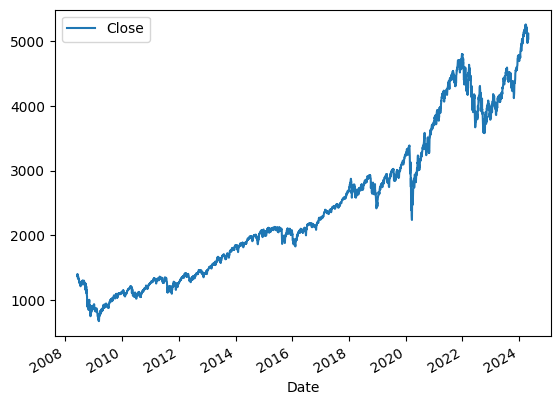

In [158]:
#Se eliminan las columnas que no se van a utilizar
# Crear un nuevo DataFrame seleccionando solo las columnas 'Date' y 'Close'
#sp500_ARIMA = sp500.iloc[:, [3]]
sp500_ARIMA = AllVar_df[['Close']]
sp500_ARIMA.plot(y="Close", use_index=True)

In [159]:
sp500_ARIMA = sp500_ARIMA.loc[fecha_inicio:]#ya que al juntar todos los datos para SARIMAX que implemento luego empiezan en esa fecha
sp500_ARIMA.head()

,Close
Date,
2014-04-30,1883.949951
2014-05-01,1883.680054
2014-05-02,1881.140015
2014-05-05,1884.660034
2014-05-06,1867.719971


In [160]:
#Verificar si hay valores nulos
missing_values = sp500_ARIMA.isnull().sum()
print(missing_values)

Close    0
dtype: int64


In [161]:
# Se convierte el índice a tipo datetime
sp500_ARIMA.index = pd.to_datetime(sp500_ARIMA.index)
# Asegurar que el índice esté en formato de fecha y ordenado
sp500_ARIMA.sort_index(inplace=True)


In [162]:
# Preparación de los datos
train_size_arima1 = int(len(sp500_ARIMA) * (1-test_size_Control))
train_arima1, test_arima1 = sp500_ARIMA['Close'][:train_size_arima1], sp500_ARIMA['Close'][train_size_arima1:]


El AIC (Criterio de Información de Akaike, por sus siglas en inglés) es una medida utilizada para la selección de modelos estadísticos. Específicamente, el AIC se utiliza para comparar la bondad de ajuste de diferentes modelos mientras penaliza la complejidad del modelo (es decir, el número de parámetros).

Fórmula del AIC
La fórmula del AIC es:

AIC = 2𝑘 − 2ln (𝐿)
AIC=2k−2ln(L)

donde:


k es el número de parámetros en el modelo.
L es el valor de la función de verosimilitud del modelo.

Interpretación
Bondad de ajuste: El término 

−2ln(L) mide qué tan bien se ajusta el modelo a los datos. Un valor más bajo indica un mejor ajuste.
Penalización por complejidad: El término 2k penaliza los modelos con más parámetros para evitar el sobreajuste (overfitting).

El objetivo es minimizar el AIC: un valor más bajo del AIC indica un modelo que logra un buen equilibrio entre la complejidad del modelo y la bondad de ajuste.

Uso del AIC en autoarima
auto.arima es una función de la librería forecast en R (y su equivalente en Python a través de la librería pmdarima) que automatiza la identificación del mejor modelo ARIMA (Autoregressive Integrated Moving Average) para una serie temporal.

¿Por qué utiliza AIC auto.arima?
Selección del mejor modelo: auto.arima prueba diferentes combinaciones de parámetros 
𝑝
p, 
𝑑
d y 
𝑞
q (que representan los componentes autoregresivos, de diferenciación y de media móvil, respectivamente) y calcula el AIC para cada combinación.

Equilibrio entre ajuste y simplicidad: Al buscar minimizar el AIC, auto.arima selecciona el modelo que no solo se ajusta bien a los datos, sino que también es lo suficientemente simple para evitar el sobreajuste.

Automatización eficiente: El uso del AIC permite a auto.arima comparar modelos de manera sistemática y eficiente, facilitando la tarea de encontrar el modelo ARIMA óptimo sin intervención manual.

Resumen
El AIC es crucial en auto.arima porque proporciona un criterio objetivo y cuantitativo para comparar modelos de diferentes complejidades, ayudando a seleccionar el modelo ARIMA que ofrece el mejor equilibrio entre ajuste a los datos y simplicidad del modelo.

In [163]:
# Ajustar el modelo AutoARIMA
model_arima1 = auto_arima(train_arima1, seasonal=False, trace=True,
                                  error_action='ignore', suppress_warnings=True,
                                  stepwise=True)

# Guardar el modelo
pickle.dump(model_arima1, open('ARIMA1_Close_best_model.pkl', 'wb'))
print("Mejor modelo ARIMA1 guardado:")
print(model_arima1.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19391.697, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19437.543, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19398.352, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19403.884, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19437.955, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19391.456, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19389.708, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=19391.193, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19395.113, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19391.630, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=19390.414, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 3.304 seconds
Mejor modelo ARIMA1 guardado:
                               SARIMAX Results                                
Dep. Variable:                    

In [165]:
# Predicciones: asumimos que test_arima1 es el conjunto de datos para validar el modelo
n_periods = len(test_arima1)
predicted_values_arima1 = model_arima1.predict(n_periods=n_periods)
predicted_values_array_arima1 = np.array(predicted_values_arima1)

c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [166]:
# Crear y guardar DataFrame con resultados
test_df_arima1 = pd.DataFrame({
    'Fecha_ARIMA1': pd.to_datetime(sp500_ARIMA.index[train_size_arima1:]),
    'Valor_Real_ARIMA1': test_arima1,
    'Prediccion_ARIMA1': predicted_values_array_arima1
})
#test_df_arima1.to_csv('ARIMA1_test_vs_predicciones.csv', index=False)

# Opcional: guardar solo los valores reales para comparar posteriormente
#valores_reales_df_arima1 = test_df_arima1[['Fecha_ARIMA1', 'Valor_Real_ARIMA1']]
#valores_reales_df_arima1.to_csv('ARIMA1_valores_reales_test.csv', index=False)

#Usar f-strings para formatear el nombre del archivo incluyendo las variables
nombre_archivo_completo = f'ARIMA1_test_vs_predicciones_{fecha_inicio}_testsize{test_size_Control}.csv'
test_df_arima1.to_csv(nombre_archivo_completo, index=False)

In [167]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
mse_test_arima1 = mean_squared_error(test_arima1, predicted_values_array_arima1)
rmse_test_arima1 = np.sqrt(mse_test_arima1)
mae_test_arima1 = mean_absolute_error(test_arima1, predicted_values_array_arima1)

print(f'ARIMA1 Test - MSE: {mse_test_arima1}, RMSE: {rmse_test_arima1}, MAE: {mae_test_arima1}')

ARIMA1 Test - MSE: 102464.24126201708, RMSE: 320.10036123381224, MAE: 274.6565770525093


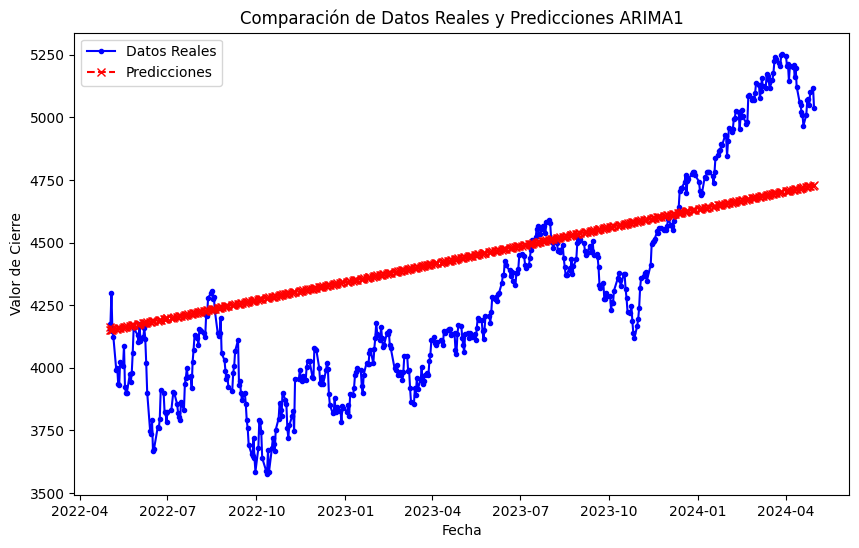

In [168]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(test_df_arima1['Fecha_ARIMA1'], test_df_arima1['Valor_Real_ARIMA1'], label='Datos Reales', marker='.', color='blue')
plt.plot(test_df_arima1['Fecha_ARIMA1'], test_df_arima1['Prediccion_ARIMA1'], label='Predicciones', marker='x', linestyle='--', color='red')
plt.title('Comparación de Datos Reales y Predicciones ARIMA1')
plt.xlabel('Fecha')
plt.ylabel('Valor de Cierre')
plt.legend()
plt.show()

Intentamos correr un SARIMAX, a ver si las vriables exogenas agregan poder de prediccion

In [169]:
#Verificamos que no hayan vlaores nulos
null_counts = AllVar_df.isnull().sum()
print("Conteo de valores nulos por columna:\n", null_counts)



Conteo de valores nulos por columna:
 Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
DAAA                            0
AAA10Y                          0
DBAA                            0
BAA10Y                          0
BAMLH0A0HYM2                    0
BAMLH0A2HYB                     0
BAMLH0A3HYC                     0
BAMLHE00EHYIOAS                 0
T10Y2Y                          0
T10Y3M                          0
T5YIE                           0
DEXUSEU                         0
DEXCHUS                         0
DEXCAUS                         0
DEXMXUS                         0
VIXCLS                          0
GVZCLS                          0
Close_oil                       0
5d_moving_avg                   0
10d_moving_avg                  0
20d_moving_avg                  0
200d_moving_avg                 0
10d_wma                         0
Momentum  

In [170]:
# Obtén una lista con todos los nombres de las columnas en el DataFrame. Una vez que corra el modelo seleccionaré las variables que sean significativas
column_names = AllVar_df.columns.tolist()
print("Nombres de columnas en AllVar_df:", column_names)


Nombres de columnas en AllVar_df: ['Open', 'High', 'Low', 'Close', 'Volume', 'DAAA', 'AAA10Y', 'DBAA', 'BAA10Y', 'BAMLH0A0HYM2', 'BAMLH0A2HYB', 'BAMLH0A3HYC', 'BAMLHE00EHYIOAS', 'T10Y2Y', 'T10Y3M', 'T5YIE', 'DEXUSEU', 'DEXCHUS', 'DEXCAUS', 'DEXMXUS', 'VIXCLS', 'GVZCLS', 'Close_oil', '5d_moving_avg', '10d_moving_avg', '20d_moving_avg', '200d_moving_avg', '10d_wma', 'Momentum', 'Stochastic_%K', 'Stochastic_%D', 'RSI_20', 'RSI_10', 'Williams_%R', 'MACD', 'Signal_Line', 'Daily Returns', 'DAAA_daily_change', 'AAA10Y_daily_change', 'DBAA_daily_change', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change', 'BAMLH0A2HYB_daily_change', 'BAMLH0A3HYC_daily_change', 'BAMLHE00EHYIOAS_daily_change', 'T10Y2Y_daily_change', 'T10Y3M_daily_change', 'T5YIE_daily_change', 'DEXUSEU_daily_change', 'DEXCHUS_daily_change', 'DEXCAUS_daily_change', 'DEXMXUS_daily_change', 'VIXCLS_daily_change', 'GVZCLS_daily_change', 'oil_daily_changes']


In [171]:
AllVar_df = AllVar_df.loc[fecha_inicio:]

In [172]:
AllVar_df.head()

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,T10Y2Y_daily_change,T10Y3M_daily_change,T5YIE_daily_change,DEXUSEU_daily_change,DEXCHUS_daily_change,DEXCAUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change,GVZCLS_daily_change,oil_daily_changes
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-30,1877.099976,1885.199951,1872.689941,1883.949951,3779230000,4.21,1.54,4.83,2.16,3.71,...,-0.881057,-1.858736,0.512821,0.449015,0.020774,-0.063851,-0.243986,-2.188184,1.371653,-1.520538
2014-05-01,1884.390015,1888.589966,1878.040039,1883.680054,3416740000,4.16,1.53,4.77,2.14,3.75,...,-1.333333,-1.515152,0.000000,-0.021629,0.000000,0.082147,-0.236940,-1.193139,-2.384021,-0.320834
2014-05-02,1885.300049,1891.329956,1878.500000,1881.140015,3159560000,4.12,1.52,4.74,2.14,3.73,...,-1.801802,-0.769231,-0.510204,-0.021634,0.000000,0.072959,-0.413714,-2.566038,-1.980198,0.341988
2014-05-05,1879.449951,1885.510010,1866.770020,1884.660034,2733730000,4.16,1.53,4.78,2.15,3.74,...,0.917431,0.775194,-1.538462,0.144259,-0.220479,-0.164039,0.073085,2.943455,4.444444,-0.280672
2014-05-06,1883.689941,1883.689941,1867.719971,1867.719971,3327260000,4.13,1.52,4.76,2.15,3.72,...,-0.909091,-0.769231,-0.520833,0.288101,-0.317038,-0.593336,-0.042282,3.837472,-3.159252,0.020101


In [173]:
#Seleccionar las columnas que se van a utilizar
selected_columns = ['Volume','VIXCLS', 'GVZCLS', 'DAAA_daily_change', 'AAA10Y_daily_change', 'DBAA_daily_change', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change', 'BAMLH0A2HYB_daily_change', 'BAMLH0A3HYC_daily_change', 'BAMLHE00EHYIOAS_daily_change', 'T10Y2Y_daily_change', 'T10Y3M_daily_change', 'T5YIE_daily_change', 'DEXUSEU_daily_change', 'DEXCHUS_daily_change', 'DEXCAUS_daily_change', 'DEXMXUS_daily_change','VIXCLS_daily_change','GVZCLS_daily_change','oil_daily_changes']

# Ahora crea un nuevo DataFrame con solo las columnas seleccionadas
X_arimax1 = AllVar_df[selected_columns]

y_arimax1= AllVar_df[['Close']]

In [174]:
# Se convierte el índice a tipo datetime
X_arimax1.index = pd.to_datetime(X_arimax1.index)
# Asegurar que el índice esté en formato de fecha y ordenado
X_arimax1.sort_index(inplace=True)

In [175]:
# Se convierte el índice a tipo datetime
y_arimax1.index = pd.to_datetime(X_arimax1.index)
# Asegurar que el índice esté en formato de fecha y ordenado
y_arimax1.sort_index(inplace=True)

In [176]:
# División de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size_arimax1 = int(len(AllVar_df) * (1-test_size_Control))
y_train_arimax1 = y_arimax1.iloc[:train_size_arimax1]
X_train_arimax1 = X_arimax1.iloc[:train_size_arimax1]

y_test_arimax1 = y_arimax1.iloc[train_size_arimax1:]
X_test_arimax1 = X_arimax1 .iloc[train_size_arimax1:]


In [177]:
# Ajustar el modelo arimax1
arimax1 = auto_arima(y_train_arimax1, X_train_arimax1, seasonal=False,
                     trace=True, error_action='ignore',
                     suppress_warnings=True, stepwise=True,
                     information_criterion='aic')  # Utilizando AIC para la selección del modelo

# Ver el resumen del modelo arimax1
print(arimax1.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17222.437, Time=3.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17220.658, Time=1.75 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17218.997, Time=1.67 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17219.382, Time=1.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30301.750, Time=1.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17214.677, Time=2.45 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=17213.903, Time=2.89 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=17189.306, Time=2.85 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=17191.001, Time=3.39 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=17191.204, Time=3.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=17215.609, Time=2.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=17192.958, Time=3.58 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=17199.668, Time=2.36 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0] intercept
Total fit time: 32.614 seconds
        

In [178]:
#Seleccionar solo las variables significativas (p-values < 0.05) -> elimino Volume, T10Y2Y_daily_change y T10Y3M_daily_change
# No uitilizo  'DAAA_daily_change' porque está muy correlacionada  'DBAA_daily_change'. Mismo argumento para no usar 'AAA10Y_daily_change' y mantner 'BAA10Y_daily_change'. Las que mantengo tienen ligermante mayor correlacion con Daily returns
#No utilizo 'BAMLHE00EHYIOAS_daily_change' porque esta corelacionada con 'BAMLH0A0HYM2_daily_change, y esta ultima tiene ligeramente mas correlacin con los daily returns
selected_columns = ['VIXCLS', 'GVZCLS', 'DBAA_daily_change', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change','T5YIE_daily_change', 'DEXUSEU_daily_change', 'DEXCHUS_daily_change', 'DEXCAUS_daily_change', 'DEXMXUS_daily_change','VIXCLS_daily_change','GVZCLS_daily_change','oil_daily_changes']

# Ahora crea un nuevo DataFrame con solo las columnas seleccionadas
X_arimax1_new = AllVar_df[selected_columns]

y_arimax1_new= AllVar_df['Close']

In [179]:
# Se convierte el índice a tipo datetime
X_arimax1_new.index = pd.to_datetime(X_arimax1.index)
# Asegurar que el índice esté en formato de fecha y ordenado
X_arimax1_new.sort_index(inplace=True)

In [80]:
# Se convierte el índice a tipo datetime
y_arimax1_new.index = pd.to_datetime(X_arimax1.index)
# Asegurar que el índice esté en formato de fecha y ordenado
y_arimax1_new.sort_index(inplace=True)

In [180]:
# División de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size_arimax1_new = int(len(AllVar_df) * (1-test_size_Control))
y_train_arimax1_new = y_arimax1_new.iloc[:train_size_arimax1_new]
X_train_arimax1_new = X_arimax1_new.iloc[:train_size_arimax1_new]

y_test_arimax1_new = y_arimax1_new.iloc[train_size_arimax1_new:]
X_test_arimax1_new = X_arimax1_new.iloc[train_size_arimax1_new:]


In [181]:
# Ajustar el modelo arimax1
arimax1_new = auto_arima(y_train_arimax1_new, X_train_arimax1_new, seasonal=False,
                     trace=True, error_action='ignore',
                     suppress_warnings=True, stepwise=True,
                     information_criterion='aic')  # Utilizando AIC para la selección del modelo

# Ver el resumen del modelo arimax1
print(arimax1_new.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17229.623, Time=5.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17244.838, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17243.166, Time=1.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17243.627, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17252.030, Time=1.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17236.389, Time=5.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17238.545, Time=2.95 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17196.384, Time=5.52 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=17224.097, Time=5.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=17205.898, Time=4.77 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=17198.478, Time=5.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=17197.516, Time=4.59 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=17208.020, Time=5.18 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=17194.786, Time=4.35 sec
 ARIMA(5,1,3)(0,0,0

repito  porque varias variables son no significativas

In [182]:
#Seleccionar solo las variables significativas (p-values < 0.05) -

selected_columns = ['VIXCLS', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change','T5YIE_daily_change', 'DEXCHUS_daily_change',  'DEXMXUS_daily_change','VIXCLS_daily_change']

# Ahora crea un nuevo DataFrame con solo las columnas seleccionadas
X_arimax2_new = AllVar_df[selected_columns]

y_arimax2_new= AllVar_df['Close']

In [183]:
# Se convierte el índice a tipo datetime
X_arimax2_new.index = pd.to_datetime(X_arimax2_new.index)
# Asegurar que el índice esté en formato de fecha y ordenado
X_arimax2_new.sort_index(inplace=True)

In [184]:
# Se convierte el índice a tipo datetime
y_arimax2_new.index = pd.to_datetime(X_arimax2_new.index)
# Asegurar que el índice esté en formato de fecha y ordenado
y_arimax2_new.sort_index(inplace=True)

In [185]:
# División de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size_arimax2_new = int(len(AllVar_df) * (1-test_size_Control))
y_train_arimax2_new = y_arimax2_new.iloc[:train_size_arimax2_new]
X_train_arimax2_new = X_arimax2_new.iloc[:train_size_arimax2_new]

y_test_arimax2_new = y_arimax2_new.iloc[train_size_arimax2_new:]
X_test_arimax2_new = X_arimax2_new.iloc[train_size_arimax2_new:]


In [186]:
# Ajustar el modelo arimax1
arimax2_new = auto_arima(y_train_arimax2_new, X_train_arimax2_new, seasonal=False,
                     trace=True, error_action='ignore',
                     suppress_warnings=True, stepwise=True,
                     information_criterion='aic')  # Utilizando AIC para la selección del modelo

# Ver el resumen del modelo arimax1
print(arimax2_new.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17231.530, Time=3.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17246.069, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17244.002, Time=0.67 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17244.509, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17253.187, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17237.533, Time=3.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17239.525, Time=2.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17195.615, Time=3.97 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=17224.917, Time=2.63 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=17207.555, Time=3.92 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=17197.618, Time=2.79 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=17196.563, Time=2.47 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=17208.884, Time=2.65 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=17194.316, Time=4.84 sec
 ARIMA(5,1,3)(0,0,0

In [101]:
# Asegúrate de que el número de períodos de predicción coincide con la longitud del conjunto de prueba
predictions_arimax2_new = arimax2_new.predict(n_periods=len(y_test_arimax2_new), X=X_test_arimax2_new)


c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [187]:
# Verificar si hay índices duplicados
print("Índices duplicados en X_test:", X_test_arimax2_new.index.duplicated().any())
print("Índices duplicados en y_test:", y_test_arimax2_new.index.duplicated().any())

# Asegúrate de que los índices estén alineados
print("Índices alineados:", (X_test_arimax2_new.index == y_test_arimax2_new.index).all())


Índices duplicados en X_test: False
Índices duplicados en y_test: False
Índices alineados: True


In [188]:
# Verificar los tipos de datos y el tamaño de los conjuntos
print("Tipos de datos en X_test_arimax2_new:", X_test_arimax2_new.dtypes)
print("Tamaño de X_test_arimax2_new:", len(X_test_arimax2_new))

print("Tipo de datos en y_test_arimax2_new:", y_test_arimax2_new.dtype)
print("Tamaño de y_test_arimax2_new:", len(y_test_arimax2_new))

# Asumiendo que predictions_arimax1_new es un array NumPy
print("Tipo de datos en predictions_arimax1_new:", predictions_arimax2_new.dtype)
print("Tamaño de predictions_arimax2_new:", len(predictions_arimax2_new))


Tipos de datos en X_test_arimax2_new: VIXCLS                       float64
BAA10Y_daily_change          float64
BAMLH0A0HYM2_daily_change    float64
T5YIE_daily_change           float64
DEXCHUS_daily_change         float64
DEXMXUS_daily_change         float64
VIXCLS_daily_change          float64
dtype: object
Tamaño de X_test_arimax2_new: 497
Tipo de datos en y_test_arimax2_new: float64
Tamaño de y_test_arimax2_new: 497
Tipo de datos en predictions_arimax1_new: float64
Tamaño de predictions_arimax2_new: 497


In [191]:
X_test_arimax2_new.head()

,VIXCLS,BAA10Y_daily_change,BAMLH0A0HYM2_daily_change,T5YIE_daily_change,DEXCHUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change
Date,,,,,,,
2022-05-02,32.34,1.463415,3.053435,-2.727273,-0.001513,0.353652,-3.173653
2022-05-03,29.25,-1.442308,-1.975309,0.000000,0.000000,-0.416034,-9.554731
2022-05-04,25.42,1.463415,3.274559,0.934579,0.000000,-0.589797,-13.094017
2022-05-05,31.20,0.961538,-1.707317,-0.308642,0.690083,0.321369,22.738002
2022-05-06,30.19,-0.476190,3.722084,-0.309598,0.174344,-0.887093,-3.237179


In [192]:
y_test_arimax2_new_df=y_test_arimax2_new.to_frame()

In [193]:
y_test_arimax2_new_df.head()

,Close
Date,
2022-05-02,4155.379883
2022-05-03,4175.479980
2022-05-04,4300.169922
2022-05-05,4146.870117
2022-05-06,4123.339844


In [194]:
predictions_arimax2_new_df=predictions_arimax2_new.to_frame()

In [195]:
predictions_arimax2_new_df.head()

,0
1984,4158.627602
1985,4192.813300
1986,4231.597114
1987,4183.163618
1988,4173.865009


In [196]:
# Cambiar directamente el nombre de la primera columna
predictions_arimax2_new_df.columns = ['Prediccion'] + predictions_arimax2_new_df.columns[1:].tolist()

# Verificar los cambios
print(predictions_arimax2_new_df.head())


       Prediccion
1984  4158.627602
1985  4192.813300
1986  4231.597114
1987  4183.163618
1988  4173.865009


In [197]:
# Verificar el tamaño de ambos DataFrames para asegurar que coinciden
print("Tamaño de predictions_arimax2_new_df:", len(predictions_arimax2_new_df))
print("Tamaño de y_test_arimax2_new:", len(y_test_arimax2_new_df))


Tamaño de predictions_arimax2_new_df: 497
Tamaño de y_test_arimax2_new: 497


In [198]:
# Asignar el índice de fechas de y_test_arimax2_new al DataFrame de predicciones
predictions_arimax2_new_df.index = y_test_arimax2_new.index

# Verificar los cambios mostrando las primeras filas del DataFrame actualizado
print(predictions_arimax2_new_df.head())


             Prediccion
Date                   
2022-05-02  4158.627602
2022-05-03  4192.813300
2022-05-04  4231.597114
2022-05-05  4183.163618
2022-05-06  4173.865009


In [199]:
# Convertir índices a datetime si aún no están convertidos
predictions_arimax2_new_df.index = pd.to_datetime(predictions_arimax2_new_df.index)
y_test_arimax2_new_df.index = pd.to_datetime(y_test_arimax2_new_df.index)


In [200]:
combined_df = pd.concat([predictions_arimax2_new_df, y_test_arimax2_new_df], axis=1)


In [201]:
nombre_archivo = f'arimax2_{fecha_inicio}_testsize{test_size_Control}.csv'
combined_df.to_csv(nombre_archivo, index=True)

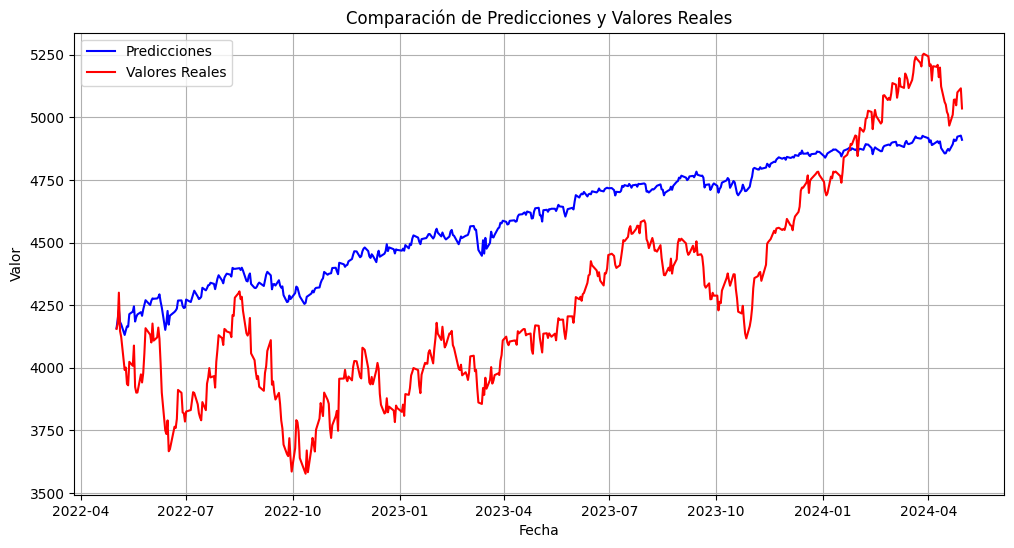

In [202]:
# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Graficar las predicciones, asegurándote de usar el nombre correcto de la columna
plt.plot(predictions_arimax2_new_df.index, predictions_arimax2_new_df['Prediccion'], label='Predicciones', color='blue')

# Graficar los valores reales
plt.plot(y_test_arimax2_new_df.index, y_test_arimax2_new_df['Close'], label='Valores Reales', color='red')

# Añadir título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()

# Añadir cuadrícula
plt.grid(True)

# Mostrar el gráfico
plt.show()


El dividir en un periodo de entrenameinto y otro de prueba para ajusta el ARIMA y ARIMAX no funciona adecumante.  Entiendo que a partir del preiddciones en el ARIMA1 van a utilizar las predicciones del día anterior para ir calculando las nuevas predicciones. por tanto , creo que por eso obtengo una línea  hacia arriba o hacia abajo dependiendo del periodo de entrenamiento que use. 

Para lidiar con este problema,utilizo una ventana expandida para hacer predicciones. La variable history_arima3 contiene inicialmente los datos de entrenamiento, y se va actualizando con los valores observados en el conjunto de prueba después de cada predicción.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19391.697, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19437.543, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19398.352, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19403.884, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19437.955, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19391.456, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19389.708, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=19391.193, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19395.113, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19391.630, Time=0.79 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=19390.414, Time=0.10 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 3.556 seconds
Test MSE: 2193.488
Test RMSE: 46.835
Test MAE: 35.563
Test MAPE: 0.853%


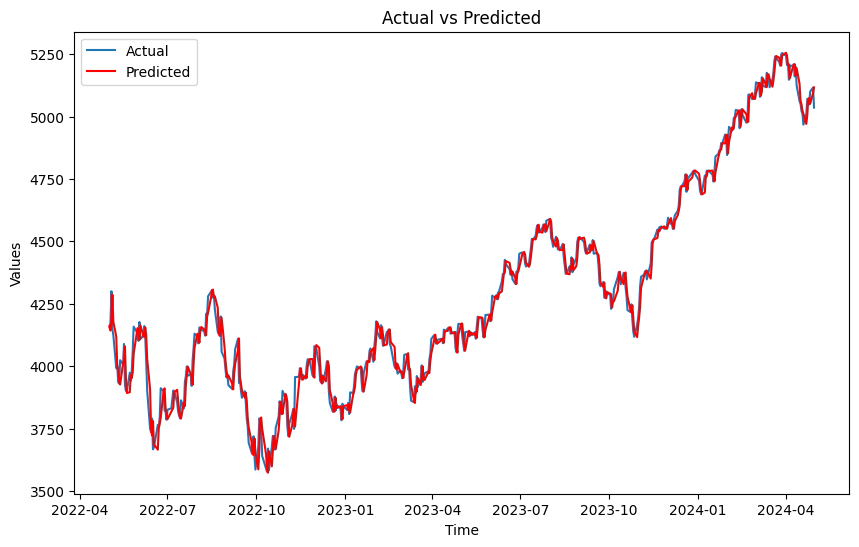

In [203]:
from statsmodels.tools.eval_measures import rmse as calc_rmse  # Renaming the imported function
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Asumiendo que sp500_ARIMA es tu DataFrame y ya está definido

train_size_arima3 = int(len(sp500_ARIMA) * (1 - test_size_Control))
train_arima3, test_arima3 = sp500_ARIMA['Close'][:train_size_arima3], sp500_ARIMA['Close'][train_size_arima3:]

# Ajustar el modelo AutoARIMA
model_returns_arima3 = auto_arima(train_arima3, seasonal=False, trace=True,
                                  error_action='ignore', suppress_warnings=True,
                                  stepwise=True)

# Hacer predicciones usando una ventana expandida
history_arima3 = [x for x in train_arima3]
predictions_arima3 = []
for t in range(len(test_arima3)):
    model = SARIMAX(history_arima3, order=model_returns_arima3.order, enforce_stationarity=True, enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions_arima3.append(yhat)
    history_arima3.append(test_arima3.iloc[t])

# Calcular y mostrar métricas adicionales
mse_arima3 = mean_squared_error(test_arima3, predictions_arima3)
rmse_val_arima3 = calc_rmse(test_arima3, predictions_arima3)  # Using the renamed function
mae_arima3 = mean_absolute_error(test_arima3, predictions_arima3)
mape_arima3 = np.mean(np.abs((test_arima3 - predictions_arima3) / test_arima3)) * 100

print(f'Test MSE: {mse_arima3:.3f}')
print(f'Test RMSE: {rmse_val_arima3:.3f}')
print(f'Test MAE: {mae_arima3:.3f}')
print(f'Test MAPE: {mape_arima3:.3f}%')

# Graficar predicciones frente a valores reales
plt.figure(figsize=(10, 6))
plt.plot(test_arima3.index, test_arima3.values, label='Actual')
plt.plot(test_arima3.index, predictions_arima3, color='red', label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


In [204]:


# Guardar los resultados en un DataFrame
results_arima3_df = pd.DataFrame({
    'Date': test_arima3.index,
    'Actual': test_arima3.values,
    'Predicted': predictions_arima3
})

# Crear el nombre del archivo CSV incluyendo referencia a arima4, fecha_inicio y test_size_Control
csv_filename = f'forecast_results_arima3_{fecha_inicio}_test_size_{test_size_Control}.csv'

# Guardar el DataFrame en un archivo CSV
results_arima3_df.to_csv(csv_filename, index=False)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19391.697, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19437.543, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19398.352, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19403.884, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19437.955, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19391.456, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19389.708, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=19391.193, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19395.113, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19391.630, Time=0.87 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=19390.414, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 3.922 seconds


c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Test MSE: 1221.370
Test RMSE: 34.948
Test MAE: 26.551
Test MAPE: 0.635%


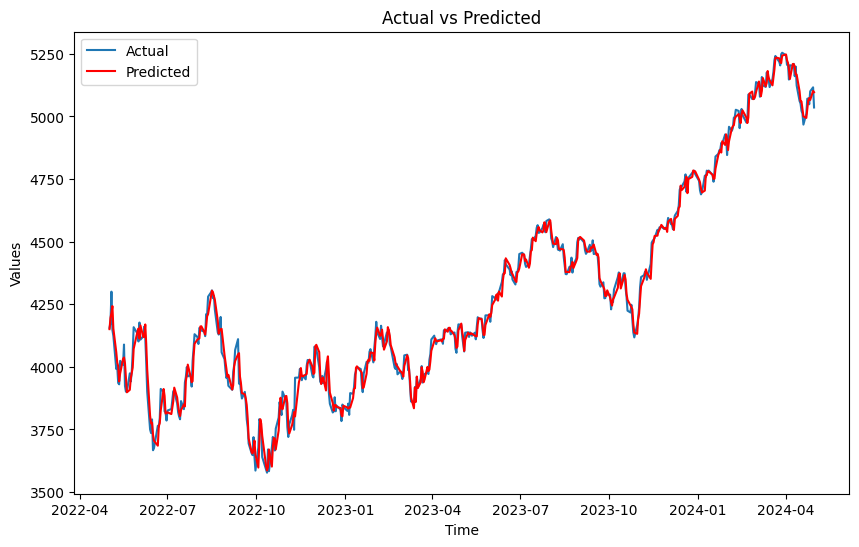

In [205]:
from statsmodels.tools.eval_measures import rmse as calc_rmse  # Renaming the imported function
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Asumiendo que sp500_ARIMAX4 y AllVar_df son tus DataFrames y ya están definidos

# Seleccionar solo las variables significativas (p-values < 0.05)
#utilizo las que dieron significativas en ArimaX2_new 'VIXCLS', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change','T5YIE_daily_change', 'DEXCHUS_daily_change',  'DEXMXUS_daily_change','VIXCLS_daily_change'
selected_columns = ['VIXCLS', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change','T5YIE_daily_change', 'DEXCHUS_daily_change',  'DEXMXUS_daily_change','VIXCLS_daily_change']

# Crear un nuevo DataFrame con solo las columnas seleccionadas
X_arimax4_new = AllVar_df[selected_columns]

# Asegurarse de que los índices de AllVar_df y sp500_ARIMAX4 estén alineados
common_index = sp500_ARIMA.index.intersection(AllVar_df.index)
sp500_ARIMAX4 = sp500_ARIMA.loc[common_index]
X_arimax4_new = X_arimax4_new.loc[common_index]

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size_arimax4 = int(len(sp500_ARIMAX4) * (1 - test_size_Control))
train_arimax4, test_arimax4 = sp500_ARIMAX4['Close'][:train_size_arimax4], sp500_ARIMAX4['Close'][train_size_arimax4:]

# Variables exógenas para entrenamiento y prueba
train_exog = X_arimax4_new[:train_size_arimax4]
test_exog = X_arimax4_new[train_size_arimax4:]

# Verificar si test_exog tiene suficientes filas
if len(test_exog) < len(test_arimax4):
    raise ValueError("test_exog debe tener al menos tantas filas como test_arimax4")

# Ajustar el modelo AutoARIMA con variables exógenas
model_returns_arimax4 = auto_arima(train_arimax4, exogenous=train_exog, seasonal=False, trace=True,
                                   error_action='ignore', suppress_warnings=True, stepwise=True)

# Hacer predicciones usando una ventana expandida
history_arimax4 = [x for x in train_arimax4]
history_exog = [x for x in train_exog.values]
predictions_arimax4 = []

for t in range(len(test_arimax4)):
    model = SARIMAX(history_arimax4, exog=np.array(history_exog), order=model_returns_arimax4.order, 
                    enforce_stationarity=True, enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1, exog=np.array(test_exog.iloc[t]).reshape(1, -1))
    yhat = output[0]
    predictions_arimax4.append(yhat)
    history_arimax4.append(test_arimax4.iloc[t])
    history_exog.append(test_exog.iloc[t])

# Calcular y mostrar métricas adicionales
mse_arimax4 = mean_squared_error(test_arimax4, predictions_arimax4)
rmse_val_arimax4 = calc_rmse(test_arimax4, predictions_arimax4)  # Using the renamed function
mae_arimax4 = mean_absolute_error(test_arimax4, predictions_arimax4)
mape_arimax4 = np.mean(np.abs((test_arimax4 - predictions_arimax4) / test_arimax4)) * 100

print(f'Test MSE: {mse_arimax4:.3f}')
print(f'Test RMSE: {rmse_val_arimax4:.3f}')
print(f'Test MAE: {mae_arimax4:.3f}')
print(f'Test MAPE: {mape_arimax4:.3f}%')

# Graficar predicciones frente a valores reales
plt.figure(figsize=(10, 6))
plt.plot(test_arimax4.index, test_arimax4.values, label='Actual')
plt.plot(test_arimax4.index, predictions_arimax4, color='red', label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


# Guardar los resultados en un DataFrame
results_arimax4_df = pd.DataFrame({
    'Date': test_arimax4.index,
    'Actual': test_arimax4.values,
    'Predicted': predictions_arimax4
})

# Crear el nombre del archivo CSV incluyendo referencia a arimax4, fecha_inicio y test_size_Control
csv_filename = f'forecast_results_arimax4_{fecha_inicio}_test_size_{test_size_Control}.csv'

# Guardar el DataFrame en un archivo CSV
results_arimax4_df.to_csv(csv_filename, index=False)